# ICU Readmissions 

In [1]:
import psycopg2
from psycopg2 import extras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

%matplotlib inline

In [2]:
def cursor_connect(cursor_factory=None):
    """
    Connects to the DB and returns the connection and cursor, ready to use.
    
    Parameters
    ----------
    cursor_factory : psycopg2.extras
    
    Returns
    -------
    (psycopg2.extensions.connection, psycopg2.extensions.cursor)
        A tuple of (psycopg2 connection, psycopg2 cursor).
    """
    #DB connection
    conn = psycopg2.connect(dbname="mimic", user="mimic", host="localhost", port="2345",
                            password="oNuemmLeix9Yex7W")
    if not cursor_factory:
        cur = conn.cursor()
    else:
        cur = conn.cursor(cursor_factory=cursor_factory)
    return conn, cur

def exec_query(query, curs_dict=True):
    """
    Execute query and returns the SQL output.
    
    Parameters
    ----------
    query: string containing SQL SELECT command
    curs_dict: dict cursor factory (output is dict)
    
    Returns
    -------
    rows: list of rows/records (SQL output)
    """
    if curs_dict == True: 
        conn, cur = cursor_connect(psycopg2.extras.DictCursor)
    else:
        conn, cur = cursor_connect()
    cur.execute(query)
    rows = cur.fetchall()
    return rows

## Identify Patients with ICU Readmissions 
Each unique patient (`subject_id`) & their corresponding number of icustays (readmission: n<sub>ICU stay</sub> > 1).

In [3]:
# query
q_icupat="""SELECT * FROM
    (SELECT subject_id, COUNT(icustay_id) AS n_icustays
    FROM icustays
    GROUP BY subject_id) AS sub_q
WHERE n_icustays > 1;"""

# Query output
icu_pat = exec_query(q_icupat, False)
df_icu_pat = pd.DataFrame(icu_pat, columns=['subjectid', 'n_icustays'])
df_icu_pat

,subjectid,n_icustays
0,7,2
1,17,2
2,21,2
3,23,2
4,34,2
5,36,3
6,41,2
7,61,2
8,67,2
9,68,3


# Care Units
  1. Mobile Intensive Care Unit (`MICU`)
  2. Cardiac Surgery Recovery Unit (`CSRU`)
  3. Surgical Intensive Care Unit (`SICU`)
  4. Neonatal Intensive Care Unit (`NICU`)
  5. Cardiac Care Unit (`CCU`)
  6. Trauma Surgical Intensive Care Unit (`TSICU`)

## Distribution of First & Last Care Units
Frequency of a care unit's use by ICU readmitted patients.

In [4]:
# query
q_cu = """SELECT subject_id, first_careunit, last_careunit
    FROM icustays;"""

# Query output
cu = exec_query(q_cu, False)
df_cu = pd.DataFrame(cu, 
                           columns=['subjectid', 'first_cu', 'last_cu'])

# filter for readmitted ICU patients
filter_preadm = list(df_icu_pat.subjectid)
df_cu_readm = df_cu[df_cu.subjectid.isin(filter_preadm)]

# map number of icustays to each patient
num_icur_map = df_icu_pat.set_index('subjectid').to_dict()['n_icustays']
num_icur = pd.Series(df_cu_readm.subjectid.map(num_icur_map), name='n_icustays')
df_cu_readm = pd.concat([df_cu_readm, num_icur], axis=1)

# Number of ICU readmitted patients per CU
fcu_ct = df_cu_readm['subjectid'].groupby(df_cu_readm['first_cu']).agg('count')
lcu_ct = df_cu_readm['subjectid'].groupby(df_cu_readm['last_cu']).agg('count')
fcu_ct.name = 'fcu_n_icustays'
lcu_ct.name = 'lcu_n_icustays'

# Extract percentages
fcur_perc = (fcu_ct / fcu_ct.sum() * 100).round(decimals=2)
fcur_perc.name = 'fcu_perc'
lcur_perc = (lcu_ct / lcu_ct.sum() * 100).round(decimals=2)
lcur_perc.name = 'lcu_perc'

df_cu_readm_grp = pd.concat([fcu_ct, lcu_ct, fcur_perc, lcur_perc], axis=1)
df_cu_readm_grp.sort_values('fcu_perc', ascending=False)

,fcu_n_icustays,lcu_n_icustays,fcu_perc,lcu_perc
MICU,10917,11052,45.85,46.42
SICU,3962,4080,16.64,17.13
CCU,3449,3385,14.48,14.22
CSRU,3175,3132,13.33,13.15
TSICU,1854,1708,7.79,7.17
NICU,454,454,1.91,1.91


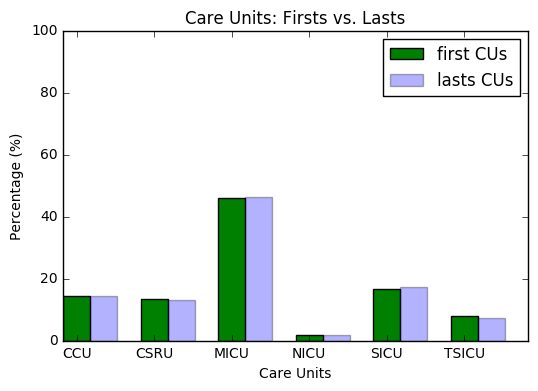

In [5]:
fig, ax = plt.subplots()
index = np.arange(6)
bar_width=0.35

rects1 = plt.bar(index, df_cu_readm_grp.fcu_perc, bar_width,
        alpha=1.0, color='g', label='first CUs')
rects2 = plt.bar(index + bar_width, df_cu_readm_grp.lcu_perc, bar_width,
        alpha=0.3, color='b', label='lasts CUs')
plt.xlabel('Care Units')
plt.ylabel('Percentage (%)')
plt.ylim([0, 100])
plt.xticks(index + bar_width/2, df_cu_readm_grp.index)
plt.legend()
plt.title('Care Units: Firsts vs. Lasts')
plt.show()

**Results**:
  * Similar distributions amongsts care units for both admission (`first_careunits`)) and discharge (`last_careunits`).
  * **Mobile Intensive Care Unit (`MICU`)** account for majority of admissions & discharge of readmitted ICU patients (~45-46%).

# Care Unit Traversals

#### Unique Combinations
n<sub>unique combo</sub> = `(n!) / (k! (n - k)!)`
  * **n**: number of sample points in a set
  * **k**: number of sample points in each combination

n<sub>ICU combo</sub> = (6!) / (2! (6-2)!) = **15 possible unique ICU traversal pairs**

#### Important Notes:
  * Care Units are defined based off the `WARDID` being associated with an ICU cost center. Thus, each ICU (`PREV_CAREUNIT` and `CURR_CAREUNIT`) is associated with a `WARDID`, but *not every* `WARDID` is an ICU.
  * Definition of a `WARDID` is not consistent. ICUs in the Beth Israel Deaconess Hospital moved throughout the year.

## Admission (`First`) - Discharge (`Last`) CU Traversal
Transfer pairs of admission and discharge ICUs for readmitted ICU patients.

### Count of Admission - Discharge  ICU Transfer Pairs
`first_cu - last_cu`

In [6]:
df_cu_readm['trans']=df_cu_readm.first_cu+'-'+df_cu_readm.last_cu
df_cu_readm

,subjectid,first_cu,last_cu,n_icustays,trans
0,109,MICU,MICU,38,MICU-MICU
1,109,MICU,MICU,38,MICU-MICU
2,109,MICU,SICU,38,MICU-SICU
3,109,SICU,MICU,38,SICU-MICU
4,109,MICU,MICU,38,MICU-MICU
5,109,MICU,MICU,38,MICU-MICU
6,109,MICU,MICU,38,MICU-MICU
7,109,SICU,SICU,38,SICU-SICU
8,109,SICU,SICU,38,SICU-SICU
9,109,MICU,MICU,38,MICU-MICU


In [7]:
df_readm_trans=df_cu_readm.groupby(['trans'])
df_readm_trans.size().sort_values(ascending=False)

trans
MICU-MICU      10411
SICU-SICU       3674
CCU-CCU         3013
CSRU-CSRU       2890
TSICU-TSICU     1580
NICU-NICU        454
CCU-MICU         228
MICU-SICU        221
SICU-MICU        183
MICU-CCU         174
CCU-CSRU         154
TSICU-MICU       137
CSRU-CCU         125
CSRU-MICU         93
TSICU-SICU        92
MICU-TSICU        63
CSRU-SICU         51
MICU-CSRU         48
SICU-CCU          42
CCU-SICU          42
SICU-TSICU        37
TSICU-CCU         31
SICU-CSRU         26
CSRU-TSICU        16
TSICU-CSRU        14
CCU-TSICU         12
dtype: int64

### Probability of Admission - Discharge ICU Transfer Pairs

In [8]:
pd.crosstab(df_cu_readm.first_cu, df_cu_readm.last_cu)/pd.crosstab(df_cu_readm.first_cu, df_cu_readm.last_cu).sum()

last_cu,CCU,CSRU,MICU,NICU,SICU,TSICU
first_cu,,,,,,
CCU,0.890103,0.049170,0.020630,0.0,0.010294,0.007026
CSRU,0.036928,0.922733,0.008415,0.0,0.012500,0.009368
MICU,0.051403,0.015326,0.942001,0.0,0.054167,0.036885
NICU,0.000000,0.000000,0.000000,1.0,0.000000,0.000000
SICU,0.012408,0.008301,0.016558,0.0,0.900490,0.021663
TSICU,0.009158,0.004470,0.012396,0.0,0.022549,0.925059


**Results**:
  * Patients are most likely to be *discharged* from the same care unit type that they were *admitted* into (~90% probability). Thus, suggesting that most patients likely have 1 ICU stay with no transfers to another care unit.

# Multiple Traversals
Explore full-scope of transfers between wards, *inclusive of admission, transfer, and discharge events*.

In [9]:
q_mult= """SELECT subject_id, hadm_id, icustay_id, eventtype,
prev_careunit, curr_careunit, prev_wardid, curr_wardid, intime, outtime, los
FROM transfers;"""
mult_trav = exec_query(q_mult, False)
mult_col = ['subjectid', 'hadmid', 'icustayid', 'eventtype', 'prev_cu', 'curr_cu', 
       'prev_wardid', 'curr_wardid', 'intime', 'outtime', 'los']
df_mult = pd.DataFrame(mult_trav, columns = mult_col)
df_mult.replace(to_replace='', value=np.nan, inplace=True, regex=True)

# filter for ICU patients with readmission
df_mult_readm = df_mult[df_mult.subjectid.isin(filter_preadm)]
df_mult_readm

,subjectid,hadmid,icustayid,eventtype,prev_cu,curr_cu,prev_wardid,curr_wardid,intime,outtime,los
5,34,115799,NaN,admit,NaN,NaN,NaN,17.0,2186-07-18 16:46:43,2186-07-18 18:10:49,1.40
6,34,115799,263086.0,transfer,NaN,MICU,17.0,23.0,2186-07-18 18:10:49,2186-07-19 11:27:20,17.28
7,34,115799,NaN,transfer,MICU,NaN,23.0,2.0,2186-07-19 11:27:20,2186-07-20 16:07:25,28.67
8,34,115799,NaN,discharge,NaN,NaN,2.0,NaN,2186-07-20 16:07:25,NaT,NaN
9,34,144319,290505.0,admit,NaN,CCU,NaN,7.0,2191-02-23 05:25:32,2191-02-23 05:33:33,0.13
10,34,144319,NaN,transfer,CCU,NaN,7.0,32.0,2191-02-23 05:33:33,2191-02-23 06:09:12,0.59
11,34,144319,290505.0,transfer,NaN,CCU,32.0,7.0,2191-02-23 06:09:12,2191-02-24 19:24:10,37.25
12,34,144319,NaN,transfer,CCU,NaN,7.0,17.0,2191-02-24 19:24:10,2191-02-25 20:20:53,24.95
13,34,144319,NaN,discharge,NaN,NaN,17.0,NaN,2191-02-25 20:20:53,NaT,NaN
19,36,182104,NaN,admit,NaN,NaN,NaN,17.0,2131-04-30 16:55:36,2131-05-04 07:40:10,86.74


## Traversals between *All* Wards
Grouped Data by `subject_id` and `hadm_id` to obtain the number of traversals between **wards** (not exclusive to just ICU wards) for each hospital admission (`hadm`) of the patients.

### Count of Ward Traversals per Hospital Admission
Total transfers between wards for each Hospital Admission

In [10]:
df_mult_readm_grp = df_mult_readm.groupby(['subjectid', 'hadmid']).size()
df_mult_readm_grp

subjectid  hadmid
7          118037     5
17         161087     4
           194023     4
21         109451     6
           111970     2
23         124321     5
           152223     4
34         115799     4
           144319     5
36         122659     6
           165660     5
           182104     5
41         101757     8
61         176332     5
           189535     5
67         155252     2
           186474     7
68         108329     5
           170467     7
85         112077     4
           116630     6
91         121205     6
94         140037     6
           183686     3
103        130744     3
           133550     3
105        128744     4
           161160     4
107        174162     3
           182383     4
                     ..
99650      190854     5
           199859    13
99660      168541     3
           189028     3
99691      140367     6
99712      159835     5
           194361     4
99715      157586     4
99756      145054     3
           154665     

In [11]:
df_mult_readm_grp = df_mult_readm.groupby(['subjectid', 'hadmid']).size()
df_mult_readm_grp = df_mult_readm_grp.to_frame(name='n_trav').reset_index()
# join DF  on subjectid to add n_readm col
df_mult_readm_grp1 = pd.merge(df_mult_readm_grp, df_icu_pat, on='subjectid', 
                        how='left')

# # Convert n_icustays col to n_readm col
df_mult_readm_grp1.rename(columns={'n_icustays': 'n_readm'}, inplace=True)
df_mult_readm_grp1.n_readm = df_mult_readm_grp1.n_readm - 1 # transformation

df_mult_readm_grp1

,subjectid,hadmid,n_trav,n_readm
0,7,118037,5,1
1,17,161087,4,1
2,17,194023,4,1
3,21,109451,6,1
4,21,111970,2,1
5,23,124321,5,1
6,23,152223,4,1
7,34,115799,4,1
8,34,144319,5,1
9,36,122659,6,2


#### Summary Statistics

In [12]:
df_mult_readm_grp1.describe()

,subjectid,hadmid,n_trav,n_readm
count,20465.000000,20465.000000,20465.000000,20465.000000
mean,32639.298314,149840.681310,4.800733,2.809431
std,27646.370031,28900.154971,2.231139,3.976283
min,7.000000,100001.000000,1.000000,1.000000
25%,11537.000000,124912.000000,3.000000,1.000000
50%,23546.000000,149795.000000,4.000000,2.000000
75%,51180.000000,174565.000000,6.000000,3.000000
max,99982.000000,199995.000000,25.000000,40.000000


In [13]:
print "Average Ward Transfers %.2f" % df_mult_readm_grp1.n_trav.mean()
print "Standard Deviation Ward Transfers %.2f" % df_mult_readm_grp1.n_trav.std()
print "Median Ward Transfers %.2f" % df_mult_readm_grp1.n_trav.median()
print "Max Ward Transfers %.2f" % df_mult_readm_grp1.n_trav.max()

Average Ward Transfers 4.80
Standard Deviation Ward Transfers 2.23
Median Ward Transfers 4.00
Max Ward Transfers 25.00


#### Distribution of Ward Transfers

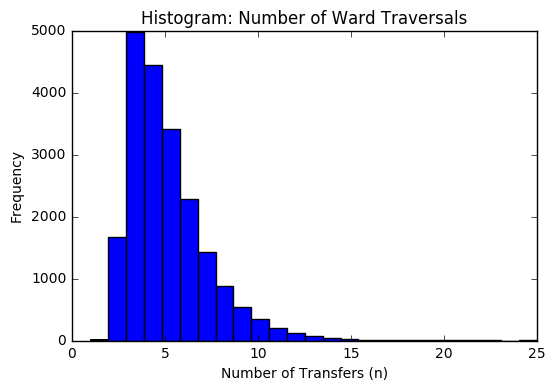

In [14]:
plt.hist(df_mult_readm_grp1.n_trav, bins=25)
plt.xlabel('Number of Transfers (n)')
plt.ylabel('Frequency')
plt.title('Histogram: Number of Ward Traversals')
plt.show()

The number of ward traversals in a hospital admission has a *right-skewed* distribution, where the right tail is longer. Thus indicating that the mean (4.8 transfers) > median (4.00 transfers).

#### Correlation: n<sub>Ward Transfers</sub> vs. n<sub>ICU Readmissions</sub>

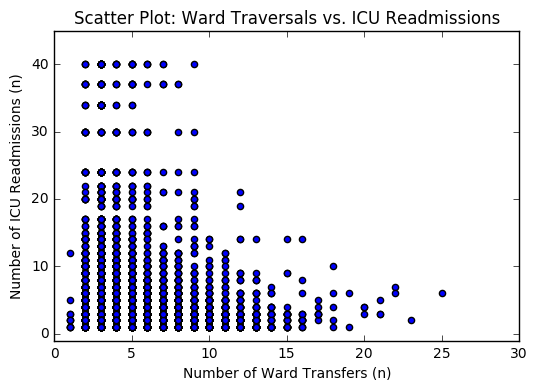

In [15]:
plt.scatter(df_mult_readm_grp1.n_trav, df_mult_readm_grp1.n_readm)
plt.xlabel('Number of Ward Transfers (n)')
plt.ylabel('Number of ICU Readmissions (n)')
plt.xlim([0, 30])
plt.ylim([-1, 45])
plt.title('Scatter Plot: Ward Traversals vs. ICU Readmissions')
plt.show()

In [16]:
pear_ward_trav = df_mult_readm_grp1.corr(method='pearson').loc['n_trav', 'n_readm']
spear_ward_trav = df_mult_readm_grp1.corr(method='spearman').loc['n_trav', 'n_readm']
print "Pearson Correlation Coefficient %.3f" % pear_ward_trav
print "Spearman Correlation Coefficient %.3f" % spear_ward_trav

Pearson Correlation Coefficient -0.073
Spearman Correlation Coefficient -0.081


The two variables (`n`<sub>all ward traversals</sub> and `n`<sub>ICU readmissions</sub>) have a weak correlation as indicated by the low `Pearson` (linear relationship) and `Spearman` (rank-order/monotonic) coefficients.

### Ward Transfer Pairs

#### Count of Pairs
Frequency of ward transfer pairs.

In [17]:
df_mult_readm_alltrans = df_mult_readm.copy()
df_mult_readm_alltrans.prev_cu.fillna('nonicu', inplace=True)
df_mult_readm_alltrans.curr_cu.fillna('nonicu', inplace=True)
df_mult_readm_alltrans['trans'] = df_mult_readm_alltrans.prev_cu+'-'+df_mult_readm_alltrans.curr_cu
df_mult_readm_alltrans

df_readm_alltrans=df_mult_readm_alltrans.groupby(['trans'])
df_readm_alltrans.size().sort_values(ascending=False)

trans
nonicu-nonicu    41247
MICU-nonicu      11806
nonicu-MICU      11580
SICU-nonicu       4342
nonicu-SICU       4284
nonicu-CCU        3702
CCU-nonicu        3681
nonicu-CSRU       3458
CSRU-nonicu       3340
nonicu-TSICU      1988
TSICU-nonicu      1840
MICU-MICU         1381
CSRU-CSRU         1114
NICU-NICU          445
SICU-SICU          427
nonicu-NICU        269
TSICU-TSICU        266
CCU-CCU            257
CCU-MICU           251
NICU-nonicu        237
NICU-NWARD         229
SICU-MICU          212
NWARD-NICU         197
MICU-SICU          186
CSRU-CCU           172
MICU-CCU           172
TSICU-MICU         144
CCU-CSRU           140
CSRU-MICU          120
NWARD-nonicu       111
TSICU-SICU          95
nonicu-NWARD        79
MICU-TSICU          77
MICU-CSRU           62
CSRU-SICU           61
SICU-CCU            53
CCU-SICU            46
TSICU-CCU           40
SICU-TSICU          34
SICU-CSRU           32
CCU-TSICU           20
CSRU-TSICU          18
TSICU-CSRU          18
NWARD

#### Probability of Ward Transfer Pairs

In [50]:
pd.crosstab(
    df_mult_readm_alltrans.prev_cu, 
    df_mult_readm_alltrans.curr_cu)/(pd.crosstab(
    df_mult_readm_alltrans.prev_cu, 
    df_mult_readm_alltrans.curr_cu).sum())

curr_cu,CCU,CSRU,MICU,NICU,NWARD,SICU,TSICU,nonicu
prev_cu,,,,,,,,
CCU,0.058462,0.029022,0.018337,0.000000,0.000000,0.009021,0.008323,0.055267
CSRU,0.039126,0.230929,0.008767,0.000000,0.000000,0.011963,0.007491,0.050147
MICU,0.039126,0.012852,0.100891,0.000000,0.000000,0.036478,0.032043,0.177257
NICU,0.000000,0.000000,0.000000,0.488474,0.711180,0.000000,0.000000,0.003558
NWARD,0.000000,0.000000,0.000000,0.216246,0.043478,0.000000,0.000000,0.001667
SICU,0.012056,0.006633,0.015488,0.000000,0.000000,0.083742,0.014149,0.065191
TSICU,0.009099,0.003731,0.010520,0.000000,0.000000,0.018631,0.110695,0.027626
nonicu,0.842129,0.716833,0.845996,0.295280,0.245342,0.840165,0.827299,0.619287


## ICU Traversals
Transfers between only ICU wards, which are considered an ICU stay (`icustay_id`).

In [19]:
df_mult_readm_icu = df_mult_readm[df_mult_readm.icustayid.notnull()==True]

#### Filter: Exclusion of Neonate Ward
Filter for neonate ward `NWARD` and NICU.

In [53]:
df_mult_readm_adult = df_mult_readm_icu[df_mult_readm_icu['prev_cu'] != 'NWARD']
df_mult_readm_adult = df_mult_readm_icu[df_mult_readm_icu['prev_cu'] != 'NICU']
df_mult_readm_adult = df_mult_readm_adult[df_mult_readm_adult['curr_cu'] != 'NWARD']
df_mult_readm_adult = df_mult_readm_adult[df_mult_readm_adult['curr_cu'] != 'NICU']
df_mult_readm_adult.sort_values('subjectid')

,subjectid,hadmid,icustayid,eventtype,prev_cu,curr_cu,prev_wardid,curr_wardid,intime,outtime,los
282,17,161087,257980.0,admit,NaN,CSRU,NaN,12.0,2135-05-09 14:12:06,2135-05-10 11:18:34,21.11
279,17,194023,277042.0,transfer,NaN,CSRU,27.0,12.0,2134-12-27 16:21:48,2134-12-29 18:04:03,49.70
303,21,111970,216859.0,admit,NaN,MICU,NaN,52.0,2135-01-30 20:53:34,2135-02-08 05:38:46,200.75
300,21,109451,217847.0,transfer,CCU,CCU,7.0,7.0,2134-09-11 22:08:22,2134-09-17 18:28:32,140.34
299,21,109451,217847.0,transfer,NaN,CCU,32.0,7.0,2134-09-11 20:50:04,2134-09-11 22:08:22,1.31
312,23,124321,234044.0,transfer,NaN,SICU,31.0,57.0,2157-10-21 11:40:38,2157-10-22 16:08:48,28.47
308,23,152223,227807.0,transfer,NaN,CSRU,27.0,14.0,2153-09-03 09:38:55,2153-09-04 15:59:11,30.34
6,34,115799,263086.0,transfer,NaN,MICU,17.0,23.0,2186-07-18 18:10:49,2186-07-19 11:27:20,17.28
11,34,144319,290505.0,transfer,NaN,CCU,32.0,7.0,2191-02-23 06:09:12,2191-02-24 19:24:10,37.25
9,34,144319,290505.0,admit,NaN,CCU,NaN,7.0,2191-02-23 05:25:32,2191-02-23 05:33:33,0.13


### Probability of Transfers to an ICU Ward (`icustay_id`)
  * Counts all ICU stays of a hospital admission, inclusive of admission and transfers.  

**Note**: Cross-Tab is discounting the transfers between ICU and non-ICU wards due to nan values. Thus, `nan` values were "filled in" and denoted by "non-icu" string.

In [54]:
# fill nan
mult_icutrav_prev = df_mult_readm_adult.prev_cu.fillna('nonicu')
mult_icutrav_curr = df_mult_readm_adult.curr_cu.fillna('nonicu')
pd.crosstab(mult_icutrav_prev, 
            mult_icutrav_curr)/pd.crosstab(mult_icutrav_prev,
                                           mult_icutrav_curr).sum()

curr_cu,CCU,CSRU,MICU,SICU,TSICU
prev_cu,,,,,
CCU,0.058462,0.029022,0.018337,0.009021,0.008323
CSRU,0.039126,0.230929,0.008767,0.011963,0.007491
MICU,0.039126,0.012852,0.100891,0.036478,0.032043
SICU,0.012056,0.006633,0.015488,0.083742,0.014149
TSICU,0.009099,0.003731,0.010520,0.018631,0.110695
nonicu,0.842129,0.716833,0.845996,0.840165,0.827299


**Results**:
  * Majority of the ICU stays resulted from patients being transferred from a `non-ICU` ward, with the *exception of NICU*.
    * CCU: 84.21%
    * CSRU: 71.68%
    * MICU: 84.60%
    * SICU: 84.02%
    * TSICU: 82.73%
  

### Count of ICU Transfers within each Hospital Admission
Total icustays within each admission (inclusive of same and different icustays)

In [22]:
df_mult_readm_hadm = df_mult_readm_adult.groupby(['subjectid', 'hadmid']).size().to_frame('n_icutrav').reset_index()

# join DF  on subjectid to add n_readm col
df_mult_readm_hadm1 = pd.merge(df_mult_readm_hadm, df_icu_pat, on='subjectid', 
                        how='left')

# # Convert n_icustays col to n_readm col
df_mult_readm_hadm1.rename(columns={'n_icustays': 'n_readm'}, inplace=True)
df_mult_readm_hadm1.n_readm = df_mult_readm_hadm1.n_readm - 1 # transformation

df_mult_readm_hadm1

,subjectid,hadmid,n_icutrav,n_readm
0,7,118037,1,1
1,17,161087,1,1
2,17,194023,1,1
3,21,109451,2,1
4,21,111970,1,1
5,23,124321,1,1
6,23,152223,1,1
7,34,115799,1,1
8,34,144319,2,1
9,36,122659,3,2


#### Summary Statistics

In [23]:
print "Average ICU Ward Traversals %.2f" % df_mult_readm_hadm1.n_icutrav.mean()
print "Standard Deviation ICU Ward Traversals %.2f" % df_mult_readm_hadm1.n_icutrav.std()
print "Median ICU Ward Traversals %.2f" % df_mult_readm_hadm1.n_icutrav.median()
print "Max ICU Ward Traversal %.2f" % df_mult_readm_hadm1.n_icutrav.max()

df_mult_readm_hadm1.describe()

Average ICU Ward Traversals 1.55
Standard Deviation ICU Ward Traversals 0.95
Median ICU Ward Traversals 1.00
Max ICU Ward Traversal 11.00


,subjectid,hadmid,n_icutrav,n_readm
count,20019.000000,20019.000000,20019.000000,20019.000000
mean,32690.404116,149863.776063,1.554723,2.827714
std,27670.470842,28886.392623,0.948436,4.000504
min,7.000000,100001.000000,1.000000,1.000000
25%,11545.500000,125007.500000,1.000000,1.000000
50%,23568.000000,149808.000000,1.000000,2.000000
75%,51301.000000,174561.000000,2.000000,3.000000
max,99982.000000,199995.000000,11.000000,40.000000


#### Distribution of ICU Ward Transfers per HADM

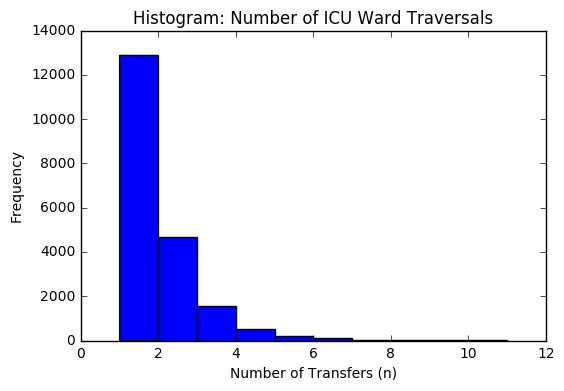

In [24]:
plt.hist(df_mult_readm_hadm1.n_icutrav, bins=10)
plt.xlabel('Number of Transfers (n)')
plt.ylabel('Frequency')
plt.title('Histogram: Number of ICU Ward Traversals')
plt.show()

The number of ICU ward traversals in a hospital admission has a *right-skewed* distribution, where the right tail is longer. Thus indicating that the mean (1.55 ICU transfers) > median (1.00 ICU transfers).

#### Correlation: ICU Ward Transfers (per HADM) vs. ICU Readmissions

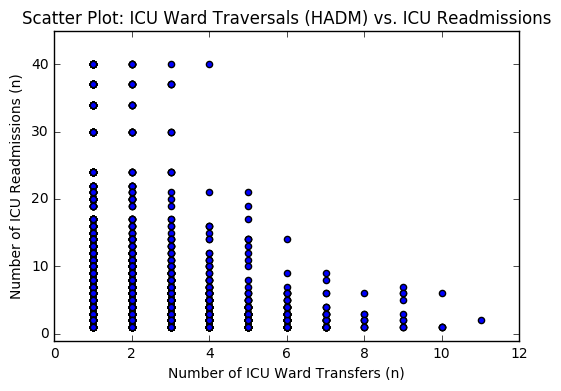

In [25]:
plt.scatter(df_mult_readm_hadm1.n_icutrav, df_mult_readm_hadm1.n_readm)
plt.xlabel('Number of ICU Ward Transfers (n)')
plt.ylabel('Number of ICU Readmissions (n)')
# plt.xlim([0, 12])
plt.ylim([-1, 45])
plt.title('Scatter Plot: ICU Ward Traversals (HADM) vs. ICU Readmissions')
plt.show()

In [26]:
pear_icu_trav = df_mult_readm_hadm1.corr(method='pearson').loc['n_icutrav', 'n_readm']
spear_icu_trav = df_mult_readm_hadm1.corr(method='spearman').loc['n_icutrav', 'n_readm']
print "Pearson Correlation Coefficient %.3f" % pear_icu_trav
print "Spearman Correlation Coefficient %.3f" % spear_icu_trav

Pearson Correlation Coefficient -0.037
Spearman Correlation Coefficient -0.042


The two variables (`n_icutrav` and `n_readm`) have a weak correlation as indicated by the low `Pearson` (linear relationship) and `Spearman` (rank-order/monotonic) coefficients.

### Count ICU Transfers within each ICU Stay
Count multiple transfers within the SAME icustay (< 24 hours)

In [27]:
df_mult_readm_icustay = df_mult_readm_adult.groupby(['subjectid', 'hadmid', 'icustayid']).size().to_frame('n_mult_icutrav').reset_index()

# join DF  on subjectid to add n_readm col
df_mult_readm_icustay1 = pd.merge(df_mult_readm_icustay, df_icu_pat, on='subjectid', 
                        how='left')

# # Convert n_icustays col to n_readm col
df_mult_readm_icustay1.rename(columns={'n_icustays': 'n_readm'}, inplace=True)
df_mult_readm_icustay1.n_readm = df_mult_readm_icustay1.n_readm - 1 # transformation

df_mult_readm_icustay1

,subjectid,hadmid,icustayid,n_mult_icutrav,n_readm
0,7,118037,278444.0,1,1
1,17,161087,257980.0,1,1
2,17,194023,277042.0,1,1
3,21,109451,217847.0,2,1
4,21,111970,216859.0,1,1
5,23,124321,234044.0,1,1
6,23,152223,227807.0,1,1
7,34,115799,263086.0,1,1
8,34,144319,290505.0,2,1
9,36,122659,211200.0,3,2


#### Summary Statistics

In [28]:
print "Average ICU Ward Traversals %.2f" % df_mult_readm_icustay1.n_mult_icutrav.mean()
print "Standard Deviation ICU Ward Traversals %.2f" % df_mult_readm_icustay1.n_mult_icutrav.std()
print "Median ICU Ward Traversals %.2f" % df_mult_readm_icustay1.n_mult_icutrav.median()
print "Max ICU Ward Traversal %.2f" % df_mult_readm_icustay1.n_mult_icutrav.max()

df_mult_readm_icustay1.describe()

Average ICU Ward Traversals 1.31
Standard Deviation ICU Ward Traversals 0.68
Median ICU Ward Traversals 1.00
Max ICU Ward Traversal 10.00


,subjectid,hadmid,icustayid,n_mult_icutrav,n_readm
count,23671.000000,23671.000000,23671.000000,23671.000000,23671.000000
mean,33150.432132,149832.172025,249879.867010,1.314858,2.783913
std,27820.491810,28924.512697,28934.276009,0.679794,3.839765
min,7.000000,100001.000000,200001.000000,1.000000,1.000000
25%,11728.000000,124921.000000,224781.000000,1.000000,1.000000
50%,23844.000000,149685.000000,250003.000000,1.000000,2.000000
75%,52556.500000,174688.500000,274983.500000,1.000000,3.000000
max,99982.000000,199995.000000,299998.000000,10.000000,40.000000


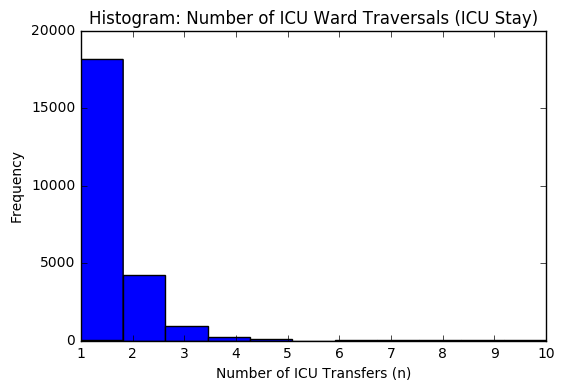

In [29]:
plt.hist(df_mult_readm_icustay1.n_mult_icutrav, bins=11)
plt.xlabel('Number of ICU Transfers (n)')
plt.ylabel('Frequency')
plt.title('Histogram: Number of ICU Ward Traversals (ICU Stay)')
plt.show()

The number of ICU ward traversals in an ICU stay has a *right-skewed* distribution, where the right tail is longer. Thus indicating that the mean (1.31 ICU transfers) > median (1.00 ICU transfers).

#### Correlation: ICU Ward Transfers (per ICU Stay) vs. ICU Readmissions 

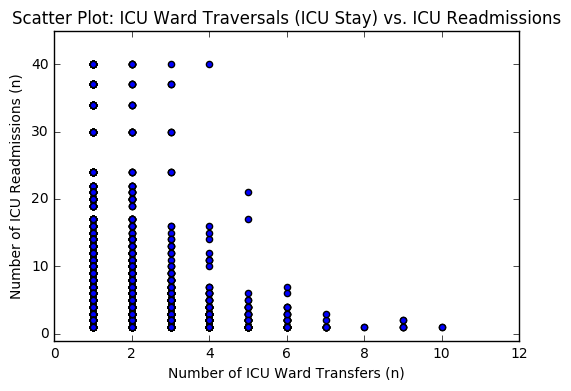

In [30]:
plt.scatter(df_mult_readm_icustay1.n_mult_icutrav, df_mult_readm_icustay1.n_readm)
plt.xlabel('Number of ICU Ward Transfers (n)')
plt.ylabel('Number of ICU Readmissions (n)')
# plt.xlim([0, 12])
plt.ylim([-1, 45])
plt.title('Scatter Plot: ICU Ward Traversals (ICU Stay) vs. ICU Readmissions')
plt.show()

In [31]:
pear_icustay_trav = df_mult_readm_icustay1.corr(method='pearson').loc['n_mult_icutrav', 'n_readm']
spear_icustay_trav = df_mult_readm_icustay1.corr(method='spearman').loc['n_mult_icutrav', 'n_readm']
print "Pearson Correlation Coefficient %.3f" % pear_icustay_trav
print "Spearman Correlation Coefficient %.3f" % spear_icustay_trav

Pearson Correlation Coefficient -0.024
Spearman Correlation Coefficient -0.026


The two variables (`n_icutrav` and `n_readm`) have a weak correlation as indicated by the low `Pearson` (linear relationship) and `Spearman` (rank-order/monotonic) coefficients. Thus, there appears to be no correlation between the number of ICU ward transfers **within an ICU stay** and the number of ICU readmissions.

# Issues

In [32]:
# cu_list = list(df_mult_readm_adult.prev_cu.value_counts().index)
# list(itertools.permutations(cu_list))


In [33]:
df_test = df_mult_readm.copy()
df_test.prev_cu.fillna('NON-ICU', inplace=True)
df_test.curr_cu.fillna('NON-ICU', inplace=True)
df_test.groupby(['subjectid', 'hadmid', 'prev_cu', 'curr_cu', 'eventtype']).size()

subjectid  hadmid  prev_cu  curr_cu  eventtype
7          118037  NICU     NWARD    transfer     2
                   NON-ICU  NICU     admit        1
                   NWARD    NICU     transfer     1
                            NON-ICU  discharge    1
17         161087  CSRU     NON-ICU  transfer     1
                   NON-ICU  CSRU     admit        1
                            NON-ICU  discharge    1
                                     transfer     1
           194023  CSRU     NON-ICU  transfer     1
                   NON-ICU  CSRU     transfer     1
                            NON-ICU  admit        1
                                     discharge    1
21         109451  CCU      CCU      transfer     1
                            NON-ICU  transfer     1
                   NON-ICU  CCU      transfer     1
                            NON-ICU  admit        1
                                     discharge    1
                                     transfer     1
           111970

In [34]:
df_test.sort_values('intime')

,subjectid,hadmid,icustayid,eventtype,prev_cu,curr_cu,prev_wardid,curr_wardid,intime,outtime,los
119428,20957,113808,NaN,admit,NON-ICU,NON-ICU,NaN,2.0,2100-06-24 22:38:00,2100-06-25 08:09:00,9.52
119430,20957,113808,NaN,transfer,NON-ICU,NON-ICU,2.0,2.0,2100-06-25 08:09:00,2100-06-26 18:43:00,34.57
119429,20957,113808,NaN,transfer,NON-ICU,NON-ICU,2.0,2.0,2100-06-25 08:09:00,2100-06-26 18:43:00,34.57
119431,20957,113808,246035.0,transfer,NON-ICU,CSRU,2.0,23.0,2100-06-26 18:43:00,2100-06-28 16:23:00,45.67
119432,20957,113808,NaN,transfer,CSRU,NON-ICU,23.0,45.0,2100-06-28 16:23:00,2100-06-30 12:05:00,43.70
19876,4521,167070,NaN,admit,NON-ICU,NON-ICU,NaN,36.0,2100-06-28 19:31:00,2100-07-15 21:47:00,410.27
119433,20957,113808,NaN,transfer,NON-ICU,NON-ICU,45.0,45.0,2100-06-30 12:05:00,2100-07-03 12:31:00,72.43
50926,9319,137275,NaN,admit,NON-ICU,NON-ICU,NaN,27.0,2100-07-01 02:10:29,2100-07-01 19:33:59,17.39
50927,9319,137275,NaN,transfer,NON-ICU,NON-ICU,27.0,24.0,2100-07-01 19:33:59,2100-07-02 01:12:19,5.64
50928,9319,137275,200237.0,transfer,NON-ICU,MICU,24.0,52.0,2100-07-02 01:12:19,2100-07-05 21:38:49,92.44


In [35]:
# d_test = dict()
# for index, row in df_test.sort_values('intime').iterrows(): #sort by time?
#     if row.eventtype == 'admit':
#         d_test[row.hadmid] = [row.curr_cu]
#     if row.eventtype == 'transfer':
#         d_test[row.hadmid] = d_test.get(row.hadmid) + [row.curr_cu]
#     if row.eventtype == 'discharge':
#         d_test[row.hadmid] = d_test.get(row.hadmid) + [row.curr_cu]
#     print d_test
    